<a href="https://colab.research.google.com/github/danhorsley/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/Copy_of_LS_DS_243_Select_models_and_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science — Practicing & Understanding Predictive Modeling_

# Hyperparameter Optimization

Today we'll use this process:

## "A universal workflow of machine learning"

_Excerpt from Francois Chollet, [Deep Learning with Python](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/README.md), Chapter 4: Fundamentals of machine learning_
 
**1. Define the problem at hand and the data on which you’ll train.** Collect this data, or annotate it with labels if need be.

**2. Choose how you’ll measure success on your problem.** Which metrics will you monitor on your validation data?

**3. Determine your evaluation protocol:** hold-out validation? K-fold validation? Which portion of the data should you use for validation?

**4. Develop a first model that does better than a basic baseline:** a model with statistical power.

**5. Develop a model that overfits.** The universal tension in machine learning is between optimization and generalization; the ideal model is one that stands right at the border between underfitting and overfitting; between undercapacity and overcapacity. To figure out where this border lies, first you must cross it.

**6. Regularize your model and tune its hyperparameters, based on performance on the validation data.** Repeatedly modify your model, train it, evaluate on your validation data (not the test data, at this point), modify it again, and repeat, until the model is as good as it can get. 

**Iterate on feature engineering: add new features, or remove features that don’t seem to be informative.** 

Once you’ve developed a satisfactory model configuration, you can **train your final production model on all the available data (training and validation) and evaluate it one last time on the test set.**


## 1. Define the problem at hand and the data on which you'll train

We'll apply the workflow to a [project from _Python Data Science Handbook_](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic) by Jake VanderPlas:

> **Predicting Bicycle Traffic**

> As an example, let's take a look at whether we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors.

> We will join the bike data with another dataset, and try to determine the extent to which weather and seasonal factors—temperature, precipitation, and daylight hours—affect the volume of bicycle traffic through this corridor. Fortunately, the NOAA makes available their daily [weather station data](http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND) (I used station ID USW00024233) and we can easily use Pandas to join the two data sources.

> Let's start by loading the two datasets, indexing by date:

So this is a regression problem, not a classification problem. We'll define the target, choose an evaluation metric, and choose models that are appropriate for regression problems.




### Download data

In [0]:
!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1616k    0 1616k    0     0   996k      0 --:--:--  0:00:01 --:--:--  996k


In [0]:
!wget https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv

--2019-05-13 16:42:09--  https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 234945 (229K) [text/plain]
Saving to: ‘BicycleWeather.csv.1’

BicycleWeather.csv. 100%[===================>] 229.44K  --.-KB/s    in 0.03s   

2019-05-13 16:42:10 (7.83 MB/s) - ‘BicycleWeather.csv.1’ saved [234945/234945]



### Load data

In [0]:
# Modified from cells 15, 16, and 20, at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic

import pandas as pd

# Download and join data into a dataframe
def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
    
    return daily

daily = load()

### First fast look at the data
- What's the shape?
- What's the date range?
- What's the target and the features?

In [0]:
daily.head()

,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
2012-10-04,3475.0,0,0,0,189,83,65,3521.0
2012-10-05,3148.0,0,0,0,217,89,57,3475.0
2012-10-06,2006.0,0,0,0,239,78,51,3148.0
2012-10-07,2142.0,0,0,0,239,78,13,2006.0
2012-10-08,3537.0,0,0,0,211,78,19,2142.0


Target
- Total : Daily total number of bicycle trips across Seattle's Fremont Bridge

Features
- Date (index) : from 2012-10-04 to 2015-09-01
- Total_yesterday : Total trips yesterday
- PRCP : Precipitation (1/10 mm)
- SNOW : Snowfall (1/10 mm)
- SNWD : Snow depth (1/10 mm)
- TMAX : Maximum temperature (1/10 Celsius)
- TMIN : Minimum temperature (1/10 Celsius)
- AWND : Average daily wind speed (1/10 meters per second)

## 2. Choose how you’ll measure success on your problem.

Which metrics will you monitor on your validation data?

This is a regression problem, so we need to choose a regression [metric](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values).



I'll choose mean absolute error.



In [0]:
from sklearn.metrics import mean_absolute_error

## 3. Determine your evaluation protocol 

We're doing model selection, hyperparameter optimization, and performance estimation. So generally we have two ideal [options](https://sebastianraschka.com/images/blog/2018/model-evaluation-selection-part4/model-eval-conclusions.jpg) to choose from:

- 3-way holdout method (train/validation/test split)
- Cross-validation with independent test set

I'll choose cross-validation with independent test set. Scikit-learn makes cross-validation convenient for us!

Specifically, I will use random shuffled cross validation to train and validate, but I will hold out an "out-of-time" test set, from the last 100 days of data:





In [43]:
train=daily[:-100] # all data up to last 100 days
test = daily[-100:] #last 100 days
train.shape, test.shape

((963, 8), (100, 8))

In [0]:
X_train=train.drop(columns='Total')
y_train=train['Total']

X_test=test.drop(columns='Total')
y_test=test['Total']


## 4. Develop a first model that does better than a basic baseline

### Look at the target's distribution and descriptive stats

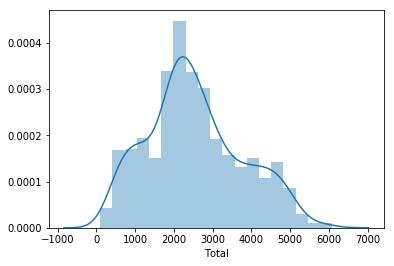

In [0]:
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);

In [0]:
y_train.describe()

count     963.000000
mean     2534.329180
std      1224.065027
min        98.000000
25%      1755.000000
50%      2381.000000
75%      3317.500000
max      6088.000000
Name: Total, dtype: float64

### Basic baseline 1

In [0]:
#can always predict mean or median
y_pred=[y_train.median()]*len(y_train)
mean_absolute_error(y_train,y_pred)

971.9376947040498

### Basic baseline 2

In [0]:
y_pred=X_train['Total_yesterday']
mean_absolute_error(y_train,y_pred)

708.061266874351

### First model that does better than a basic baseline

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

scores = cross_validate(LinearRegression(),X_train, y_train,scoring='neg_mean_absolute_error',cv=3,
                        return_train_score=True,return_estimator=True)

In [0]:
pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,0.037526,0.001849,"LinearRegression(copy_X=True, fit_intercept=Tr...",-555.186275,-619.509206
1,0.003861,0.001262,"LinearRegression(copy_X=True, fit_intercept=Tr...",-651.126513,-583.427702
2,0.002774,0.001193,"LinearRegression(copy_X=True, fit_intercept=Tr...",-615.965800,-589.341301


In [0]:
for i, model in enumerate(scores['estimator']):
  coefficients=model.coef_
  intercept=model.intercept_
  feature_names=X_train.columns
  
  print(f'Model from cross-validation fold#{i}')
  print('Intercept',intercept)
  print(pd.Series(coefficients,feature_names).to_string())
  print('/n')

Model from cross-validation fold#0
Intercept 566.7766337283679
PRCP               -3.525103
SNOW               -0.082029
SNWD              -12.045027
TMAX                9.475238
TMIN               -4.607775
AWND               -2.745191
Total_yesterday     0.417360
/n
Model from cross-validation fold#1
Intercept 671.9064515706045
PRCP               -2.772253
SNOW               -0.000995
SNWD               20.800688
TMAX                8.804948
TMIN               -3.741386
AWND               -6.108300
Total_yesterday     0.405074
/n
Model from cross-validation fold#2
Intercept 465.84525362296563
PRCP               -2.876196
SNOW               -0.016432
SNWD               -8.809696
TMAX               10.419441
TMIN               -5.862868
AWND               -2.398991
Total_yesterday     0.423493
/n


## 5. Develop a model that overfits. 

"The universal tension in machine learning is between optimization and generalization; the ideal model is one that stands right at the border between underfitting and overfitting; between undercapacity and overcapacity. To figure out where this border lies, first you must cross it." —Chollet

<img src="https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-validation-curve.png">

Diagram Source: https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn

### Random Forest?

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [0]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, max_depth=None, n_jobs=-1)
scores = cross_validate(model, X_train, y_train, scoring='neg_mean_absolute_error',
                       cv=3, return_train_score=True,
                       return_estimator=True)

In [0]:
pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,0.217391,0.009844,"(DecisionTreeRegressor(criterion='mse', max_de...",-565.462991,-245.936682
1,0.212353,0.009876,"(DecisionTreeRegressor(criterion='mse', max_de...",-635.650872,-223.130249
2,0.211661,0.010347,"(DecisionTreeRegressor(criterion='mse', max_de...",-643.010249,-224.415031


In [0]:
-scores['test_score'].mean()

614.7080373831776

### Validation Curve

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html

> Validation curve. Determine training and test scores for varying parameter values. This is similar to grid search with one parameter.

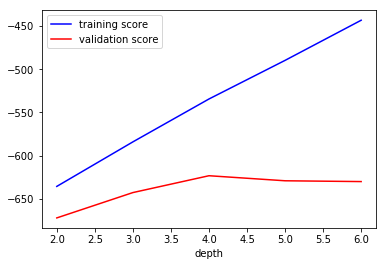

In [0]:
# Modified from cell 13 at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve

model = RandomForestRegressor(n_estimators=100)

depth = [2, 3, 4, 5, 6]
train_score, val_score = validation_curve(
    model, X_train, y_train,
    param_name='max_depth', param_range=depth, 
    scoring='neg_mean_absolute_error', cv=3)

plt.plot(depth, np.median(train_score, 1), color='blue', label='training score')
plt.plot(depth, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('depth');

### `RandomizedSearchCV`

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

https://scikit-learn.org/stable/modules/grid_search.html

In [0]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_estimators': [100, 200], 
    'max_depth': [4, 5], 
    'criterion': ['mse', 'mae']
}

gridsearch = RandomizedSearchCV(
    RandomForestRegressor(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=4, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    9.3s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=-1, oob_score=False,
                                                   random_state=42,

In [0]:
results=pd.DataFrame(gridsearch.cv_results_)
results.sort_values(by='rank_test_score').head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.943506,0.224379,0.10349,0.000171,200,5,mae,"{'n_estimators': 200, 'max_depth': 5, 'criteri...",-537.343224,-633.188069,-611.812399,-594.114564,41.080965,1,-514.399139,-476.132208,-486.784755,-492.438701,16.125856


In [0]:
gridsearch.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

## FEATURE ENGINEERING!

Jake VanderPlas demonstrates this feature engineering: 
https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic

In [0]:
# Modified from code cells 17-21 at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic

def jake_wrangle(X):  
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)


    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)


    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))

    
    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10
    
    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])

    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.

    return X

X_train = jake_wrangle(X_train)

### Linear Regression (with new features)

In [0]:
scores = cross_validate(LinearRegression(),X_train, y_train,scoring='neg_mean_absolute_error',cv=3,
                        return_train_score=True,return_estimator=True)

In [0]:
pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,0.007560,0.001456,"LinearRegression(copy_X=True, fit_intercept=Tr...",-297.692524,-294.532315
1,0.003123,0.001308,"LinearRegression(copy_X=True, fit_intercept=Tr...",-300.419037,-283.779461
2,0.003137,0.001319,"LinearRegression(copy_X=True, fit_intercept=Tr...",-322.640378,-283.509114


### Random Forest (with new features)

In [0]:
model = RandomForestRegressor(n_estimators=100, max_depth=None, n_jobs=-1)
scores = cross_validate(model, X_train, y_train, scoring='neg_mean_absolute_error',
                       cv=3, return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,0.344048,0.009236,"(DecisionTreeRegressor(criterion='mse', max_de...",-330.693022,-105.475374
1,0.338830,0.009934,"(DecisionTreeRegressor(criterion='mse', max_de...",-331.492399,-99.348598
2,0.340968,0.010051,"(DecisionTreeRegressor(criterion='mse', max_de...",-289.367695,-109.859579


In [0]:
param_distributions = {
    'n_estimators': [100], 
    'max_depth': [5,10,15], 
    'criterion': [ 'mae']
}

gridsearch = RandomizedSearchCV(
    RandomForestRegressor(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=4, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 3 is smaller than n_iter=4. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   13.5s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   16.0s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=-1, oob_score=False,
                                                   random_state=42,

In [0]:
results=pd.DataFrame(gridsearch.cv_results_)
results.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
2,3.178668,0.627877,0.107753,0.005822,100,15,mae,"{'n_estimators': 100, 'max_depth': 15, 'criter...",-347.235405,-319.651340,-304.428754,-323.771833,17.716963,1,-112.552009,-102.188061,-116.336075,-110.358715,5.980495
1,3.271555,0.012151,0.116058,0.004497,100,10,mae,"{'n_estimators': 100, 'max_depth': 10, 'criter...",-349.442196,-324.468287,-297.640561,-323.850348,21.152443,2,-143.936106,-128.380117,-145.615195,-139.310472,7.759267
0,2.192609,0.134153,0.110290,0.009375,100,5,mae,"{'n_estimators': 100, 'max_depth': 5, 'criteri...",-360.615374,-387.242134,-335.736137,-361.197882,21.031269,3,-299.174914,-266.206192,-294.979984,-286.787030,14.653271



### Feature engineering, explained by Francois Chollet

> _Feature engineering_ is the process of using your own knowledge about the data and about the machine learning algorithm at hand to make the algorithm work better by applying hardcoded (nonlearned) transformations to the data before it goes into the model. In many cases, it isn’t reasonable to expect a machine-learning model to be able to learn from completely arbitrary data. The data needs to be presented to the model in a way that will make the model’s job easier.

> Let’s look at an intuitive example. Suppose you’re trying to develop a model that can take as input an image of a clock and can output the time of day.

> If you choose to use the raw pixels of the image as input data, then you have a difficult machine-learning problem on your hands. You’ll need a convolutional neural network to solve it, and you’ll have to expend quite a bit of computational resources to train the network.

> But if you already understand the problem at a high level (you understand how humans read time on a clock face), then you can come up with much better input features for a machine-learning algorithm: for instance, write a Python script to follow the black pixels of the clock hands and output the (x, y) coordinates of the tip of each hand. Then a simple machine-learning algorithm can learn to associate these coordinates with the appropriate time of day.

> You can go even further: do a coordinate change, and express the (x, y) coordinates as polar coordinates with regard to the center of the image. Your input will become the angle theta of each clock hand. At this point, your features are making the problem so easy that no machine learning is required; a simple rounding operation and dictionary lookup are enough to recover the approximate time of day.

> That’s the essence of feature engineering: making a problem easier by expressing it in a simpler way. It usually requires understanding the problem in depth.

> Before convolutional neural networks became successful on the MNIST digit-classification problem, solutions were typically based on hardcoded features such as the number of loops in a digit image, the height of each digit in an image, a histogram of pixel values, and so on.

> Neural networks are capable of automatically extracting useful features from raw data. Does this mean you don’t have to worry about feature engineering as long as you’re using deep neural networks? No, for two reasons:

> - Good features still allow you to solve problems more elegantly while using fewer resources. For instance, it would be ridiculous to solve the problem of reading a clock face using a convolutional neural network.
> - Good features let you solve a problem with far less data. The ability of deep-learning models to learn features on their own relies on having lots of training data available; if you have only a few samples, then the information value in their features becomes critical.


# ASSIGNMENT

**1.** Complete the notebook cells that were originally commented **`TODO`**. 

**2.** Then, focus on feature engineering to improve your cross validation scores. Collaborate with your cohort on Slack. You could start with the ideas [Jake VanderPlas suggests:](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic)

> Our model is almost certainly missing some relevant information. For example, nonlinear effects (such as effects of precipitation and cold temperature) and nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temperatures) cannot be accounted for in this model. Additionally, we have thrown away some of the finer-grained information (such as the difference between a rainy morning and a rainy afternoon), and we have ignored correlations between days (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days). These are all potentially interesting effects, and you now have the tools to begin exploring them if you wish!

**3.** Experiment with the Categorical Encoding notebook.

**4.** At the end of the day, take the last step in the "universal workflow of machine learning" — "You can train your final production model on all the available data (training and validation) and evaluate it one last time on the test set."

See the [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) documentation for the `refit` parameter, `best_estimator_` attribute, and `predict` method:

> **refit : boolean, or string, default=True**

> Refit an estimator using the best found parameters on the whole dataset.

> The refitted estimator is made available at the `best_estimator_` attribute and permits using `predict` directly on this `GridSearchCV` instance.

### STRETCH

**A.** Apply this lesson other datasets you've worked with, like Ames Housing, Bank Marketing, or others.

**B.** In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.

**C.** _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?

In [0]:
daily.head()

,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
2012-10-04,3475.0,0,0,0,189,83,65,3521.0
2012-10-05,3148.0,0,0,0,217,89,57,3475.0
2012-10-06,2006.0,0,0,0,239,78,51,3148.0
2012-10-07,2142.0,0,0,0,239,78,13,2006.0
2012-10-08,3537.0,0,0,0,211,78,19,2142.0


In [60]:
X_train.columns

Index(['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND', 'Total_yesterday',
       'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
       'daylight_hrs', 'Temp (C)', 'dry day', 'annual'],
      dtype='object')

In [83]:
#snow has some bad values
X_train[X_train['SNOW']<0]['SNOW']

Series([], Name: SNOW, dtype: int64)

In [110]:
X_train.index.hour

Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            ...
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           dtype='int64', length=963)

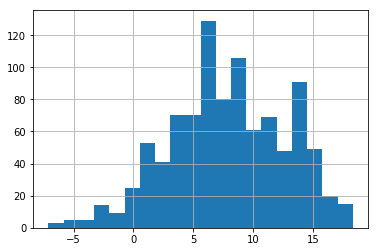

In [56]:
X_train['TMIN'].hist(bins=20)

In [0]:
#let's make some new weather based columns

def new_features(frame):
  frame['SNOW']=np.where(frame['SNOW']<-1000,0,frame['SNOW'])
  frame['very_hot']=np.where(frame['TMAX']>30,1,0)
  frame['very_cold']=np.where(frame['TMIN']<5,1,0)
  frame['rained_yesterday']=np.where(frame['PRCP'].shift(1)>0.15,1,0)
  frame['sunny_after_rain']=np.where((frame['PRCP'].shift(1)>0.15) &
                                       (frame['PRCP'].shift(2)>0.15) &
                                        (frame['PRCP'].shift(3)>0.15) &
                                        (frame['dry day']==1),1,0)
  frame['rainy_and_cold']=np.where((frame['PRCP']>0.15) & (frame['TMIN']<5),1,0)

  
  return frame

In [78]:
X_train_new=new_features(X_train)
X_train_new.head(1)

,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,...,holiday,daylight_hrs,Temp (C),dry day,annual,very_hot,very_cold,rained_yesterday,sunny_after_rain,rainy_and_cold
2012-10-04,0.0,0,0,18.9,8.3,65,3521.0,0.0,0.0,0.0,...,0.0,11.219142,13.6,1,0.0,0,0,0,0,0


In [86]:
#after several iterations, consitently teh best score was achieved by 9 max depth and 130 estimators
param_distributions = {
    'n_estimators': [130,140,150], 
    'max_depth': [9], 
    'criterion': [ 'mae']
}

gridsearch = RandomizedSearchCV(
    RandomForestRegressor(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=4, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

gridsearch.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 3 is smaller than n_iter=4. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   20.3s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   23.6s finished
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   23.6s remaining:    0.0s


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=-1, oob_score=False,
                                                   random_state=42,

In [85]:
pd.DataFrame(gridsearch.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
3,4.738021,0.044642,0.108042,0.006361,130,9,mae,"{'n_estimators': 130, 'max_depth': 9, 'criteri...",-336.317110,-328.717757,-297.556506,-320.863791,16.770206,1,-158.226000,-141.640271,-161.195477,-153.687249,8.604329
2,4.855627,0.091768,0.112447,0.006303,130,10,mae,"{'n_estimators': 130, 'max_depth': 10, 'criter...",-342.335981,-323.475174,-298.580781,-321.463979,17.919506,2,-141.645189,-127.474970,-144.099293,-137.739817,7.327163
0,4.299363,0.094482,0.111735,0.011508,120,10,mae,"{'n_estimators': 120, 'max_depth': 10, 'criter...",-343.249039,-324.033658,-299.312941,-322.198546,17.983713,3,-141.992893,-127.763324,-145.047066,-138.267761,7.531684
1,3.919323,0.097307,0.111007,0.005836,120,7,mae,"{'n_estimators': 120, 'max_depth': 7, 'criteri...",-335.744782,-342.581529,-309.231036,-329.185782,14.383537,4,-208.623728,-189.525526,-212.002875,-203.384043,9.896078


In [89]:
best_RFR=RandomForestRegressor(max_depth=9,n_estimators=130,n_jobs=-1, random_state=42)
best_RFR.fit(X_train,y_train)
feature_importances=pd.DataFrame(X_train.columns)
feature_importances['importance']=best_RFR.feature_importances_
feature_importances.sort_values(by='importance',ascending=False)

,0,importance
3,TMAX,0.419849
6,Total_yesterday,0.181556
12,Sat,0.131876
13,Sun,0.075438
0,PRCP,0.068205
15,daylight_hrs,0.038513
7,Mon,0.032486
18,annual,0.008965
14,holiday,0.008827
5,AWND,0.007774


In [93]:
#trying XGBRegressor - i've had a few iterations here
from xgboost import XGBRegressor

param_distributions = {
    'n_estimators': [90,100,115,120], 
    'max_depth': [4,5,6], 
    'booster': [ 'dart']  #'gbtree', 'gblinear',
}

gridsearchX = RandomizedSearchCV(
    XGBRegressor(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=4, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

gridsearchX.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.4s finished
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=-1, nthread=None,
                                          objective='reg:linear',
                                          random_state=42, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=True, subsample=1),
                   iid='warn', n_iter=4, n_jobs=-1,
                   param_

In [94]:
#so signifigantly better scores with xgb boost - dart with 4 depth and 100 estimators
pd.DataFrame(gridsearchX.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_booster,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.252425,0.004983,0.003774,0.000162,100,4,dart,"{'n_estimators': 100, 'max_depth': 4, 'booster...",-262.864709,-310.215195,-272.524596,-281.868167,20.428638,1,-128.740588,-128.894492,-134.670964,-130.768681,2.760046
2,0.255434,0.005817,0.003906,0.000183,90,5,dart,"{'n_estimators': 90, 'max_depth': 5, 'booster'...",-293.530109,-318.042112,-273.980775,-295.184332,18.025957,2,-86.147895,-91.894195,-96.416279,-91.486123,4.201969
3,0.409598,0.014065,0.004648,0.000295,120,5,dart,"{'n_estimators': 120, 'max_depth': 5, 'booster...",-300.692197,-316.327214,-270.985214,-296.001542,18.805601,3,-69.693808,-76.118617,-77.495251,-74.435892,3.399931
1,0.458076,0.003640,0.004833,0.000204,115,6,dart,"{'n_estimators': 115, 'max_depth': 6, 'booster...",-294.656687,-312.507608,-316.463524,-307.875940,9.485912,4,-41.817764,-46.129056,-46.475920,-44.807580,2.118856


In [0]:
from sklearn.model_selection import cross_val_score
#getting rid of warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [109]:
#using various combinations of features to find the best
best_errors=[]
best_XGB=XGBRegressor(max_depth=4,n_estimators=100,booster='dart',n_jobs=-1, random_state=42)
import random
for i in range (0,100):
  random.shuffle(even_less_features)
  temp_features=less_features[:17]
  best_XGB.fit(X_train[temp_features],y_train)
  score = cross_val_score(best_XGB, X_train[temp_features], y_train, scoring='neg_mean_absolute_error', cv=5).mean()
  if score>-274:
    _=(score,temp_features)
    best_errors.append(_)

print(best_errors)

[]


In [0]:
less_features=['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND', 'Total_yesterday',
       'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
       'daylight_hrs', 'Temp (C)', 'dry day', 'annual', 'very_hot',
       'very_cold', 'rained_yesterday', 'sunny_after_rain', 'rainy_and_cold']
even_less_features=['SNWD', 'Fri', 'holiday', 'Thu', 'PRCP', 'AWND', 'TMAX',
                    'Sun', 'TMIN', 'very_cold', 'rainy_and_cold',
                    'Total_yesterday', 'Tue', 'SNOW', 'rained_yesterday',
                    'dry day', 'Mon', 'daylight_hrs', 'Sat', 'sunny_after_rain']

In [113]:
best_XGB.fit(X_train_new[even_less_features],y_train)

#now using this final combo on test data
#best_XGB=XGBRegressor(max_depth=4,n_estimators=100,booster='dart',n_jobs=-1, random_state=42)
X_test_new=jake_wrangle(X_test)
X_test_new=new_features(X_test_new)
X_test_new=X_test_new[even_less_features]

y_pred = best_XGB.predict(X_test_new)

mean_absolute_error(y_test,y_pred)

267.6331768798828

In [0]:
#looks like a decent improvement!